# Notebook 04 : Gestion du Déséquilibre des Classes

**Projet 7 - Prêt à dépenser : Scoring Crédit**

## Objectifs

Ce notebook traite le problème du déséquilibre des classes dans notre jeu de données de crédit. Nous comparons plusieurs approches de rééquilibrage selon les bonnes pratiques de data science :

### Méthodes testées (imbalanced-learn)

1. **Undersampling** : RandomUnderSampler
2. **Oversampling** : SMOTE (Synthetic Minority Over-sampling Technique)
3. **Combinaison** : SMOTEENN (SMOTE + Edited Nearest Neighbours)

### Métriques d'évaluation

- **Métriques techniques** : Recall, Precision, F1-Score, ROC-AUC
- **Métrique métier** : Coût métier personnalisé prenant en compte :
  - Coût d'un faux négatif (prêt accordé à un défaillant)
  - Coût d'un faux positif (prêt refusé à un bon client)

### Approche

1. Baseline sans correction
2. Application de chaque méthode
3. Évaluation avec métriques techniques et métier
4. Comparaison visuelle et décision finale
5. Sauvegarde de la stratégie retenue

---

## 1. Configuration et Imports

In [1]:
%matplotlib inline
# Imports standards
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix, 
    classification_report,
    roc_auc_score, 
    recall_score, 
    precision_score, 
    f1_score,
    roc_curve,
    auc
)

# Imbalanced-learn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN

# Configuration des graphiques
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("Imports réalisés avec succès")

Imports réalisés avec succès


In [2]:
# Configuration des chemins
from pathlib import Path

# Déterminer le répertoire de base
BASE_DIR = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
ARTIFACTS_DIR = BASE_DIR / 'artifacts'
FIGURES_DIR = BASE_DIR / 'figures'

# Créer le dossier figures s'il n'existe pas
FIGURES_DIR.mkdir(exist_ok=True)

print(f"Répertoire de base : {BASE_DIR}")
print(f"Artifacts : {ARTIFACTS_DIR}")
print(f"Figures : {FIGURES_DIR}")
print(f"\nVérification :")
print(f"  Artifacts existe : {ARTIFACTS_DIR.exists()}")
print(f"  Figures existe : {FIGURES_DIR.exists()}")

Répertoire de base : C:\Users\Utilisateur\Downloads\notebookmentordemain
Artifacts : C:\Users\Utilisateur\Downloads\notebookmentordemain\artifacts
Figures : C:\Users\Utilisateur\Downloads\notebookmentordemain\figures

Vérification :
  Artifacts existe : True
  Figures existe : True


## 2. Fonctions Utilitaires

In [3]:
# Fonction nécessaire pour le chargement du preprocesseur
def convert_to_string(X):
    """Convertit toutes les valeurs en string pour OneHotEncoder"""
    import pandas as pd
    if isinstance(X, pd.DataFrame):
        return X.astype(str)
    else:
        return pd.DataFrame(X).astype(str).values

print("Fonction convert_to_string définie")

Fonction convert_to_string définie


In [4]:
# Fonction de coût métier
def cout_metier(y_true, y_pred, cout_fn=10, cout_fp=1):
    """
    Calcule le coût métier total basé sur les faux négatifs et faux positifs.
    
    Paramètres:
    -----------
    y_true : array-like
        Vraies étiquettes
    y_pred : array-like
        Prédictions
    cout_fn : float, default=10
        Coût d'un faux négatif (prêt accordé à un défaillant)
    cout_fp : float, default=1
        Coût d'un faux positif (prêt refusé à un bon client)
    
    Returns:
    --------
    float : Coût total
    dict : Détail des coûts
    """
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Calcul des coûts
    cout_total = (fn * cout_fn) + (fp * cout_fp)
    
    # Détails
    details = {
        'cout_total': cout_total,
        'faux_negatifs': fn,
        'faux_positifs': fp,
        'cout_fn_total': fn * cout_fn,
        'cout_fp_total': fp * cout_fp,
        'ratio_fn_fp': cout_fn / cout_fp
    }
    
    return cout_total, details

print("Fonction de coût métier définie")
print("Paramètres par défaut :")
print("  - Coût faux négatif : 10 (prêt accordé à défaillant)")
print("  - Coût faux positif : 1 (prêt refusé à bon client)")

Fonction de coût métier définie
Paramètres par défaut :
  - Coût faux négatif : 10 (prêt accordé à défaillant)
  - Coût faux positif : 1 (prêt refusé à bon client)


## 3. Chargement des Données

In [5]:
print("Chargement des artifacts du Notebook 02...\n")

# 1. Chargement du preprocesseur
preprocesseur = joblib.load(ARTIFACTS_DIR / 'preprocesseur.joblib')
print("[1/3] Preprocesseur chargé")

# 2. Chargement des données splitées
X_train, X_valid, y_train, y_valid = joblib.load(ARTIFACTS_DIR / 'data_split.joblib')
print("[2/3] Data split chargé")
print(f"      X_train : {X_train.shape}")
print(f"      X_valid : {X_valid.shape}")
print(f"      y_train : {y_train.shape}")
print(f"      y_valid : {y_valid.shape}")

# 3. Chargement des noms de features
feature_names = joblib.load(ARTIFACTS_DIR / 'feature_names.joblib')
print(f"[3/3] Feature names chargé ({len(feature_names)} features)")

print("\nTous les artifacts chargés avec succès")

Chargement des artifacts du Notebook 02...

[1/3] Preprocesseur chargé
[2/3] Data split chargé
      X_train : (246005, 794)
      X_valid : (61502, 794)
      y_train : (246005,)
      y_valid : (61502,)
[3/3] Feature names chargé (794 features)

Tous les artifacts chargés avec succès


## 4. Analyse du Déséquilibre Initial

In [6]:
# Analyse de la distribution des classes
print("=" * 70)
print("ANALYSE DU DÉSÉQUILIBRE DES CLASSES")
print("=" * 70)

# Distribution y_train
dist_train = y_train.value_counts(normalize=True).sort_index()
count_train = y_train.value_counts().sort_index()

print("\nTrain set :")
print(f"  Classe 0 (Bon client) : {count_train[0]:,} ({dist_train[0]*100:.2f}%)")
print(f"  Classe 1 (Défaillant)  : {count_train[1]:,} ({dist_train[1]*100:.2f}%)")
print(f"  Ratio déséquilibre : 1:{count_train[0]/count_train[1]:.1f}")

# Distribution y_valid
dist_valid = y_valid.value_counts(normalize=True).sort_index()
count_valid = y_valid.value_counts().sort_index()

print("\nValidation set :")
print(f"  Classe 0 (Bon client) : {count_valid[0]:,} ({dist_valid[0]*100:.2f}%)")
print(f"  Classe 1 (Défaillant)  : {count_valid[1]:,} ({dist_valid[1]*100:.2f}%)")
print(f"  Ratio déséquilibre : 1:{count_valid[0]/count_valid[1]:.1f}")

ANALYSE DU DÉSÉQUILIBRE DES CLASSES

Train set :
  Classe 0 (Bon client) : 226,145 (91.93%)
  Classe 1 (Défaillant)  : 19,860 (8.07%)
  Ratio déséquilibre : 1:11.4

Validation set :
  Classe 0 (Bon client) : 56,537 (91.93%)
  Classe 1 (Défaillant)  : 4,965 (8.07%)
  Ratio déséquilibre : 1:11.4


Figure sauvegardée : desequilibre_initial.png


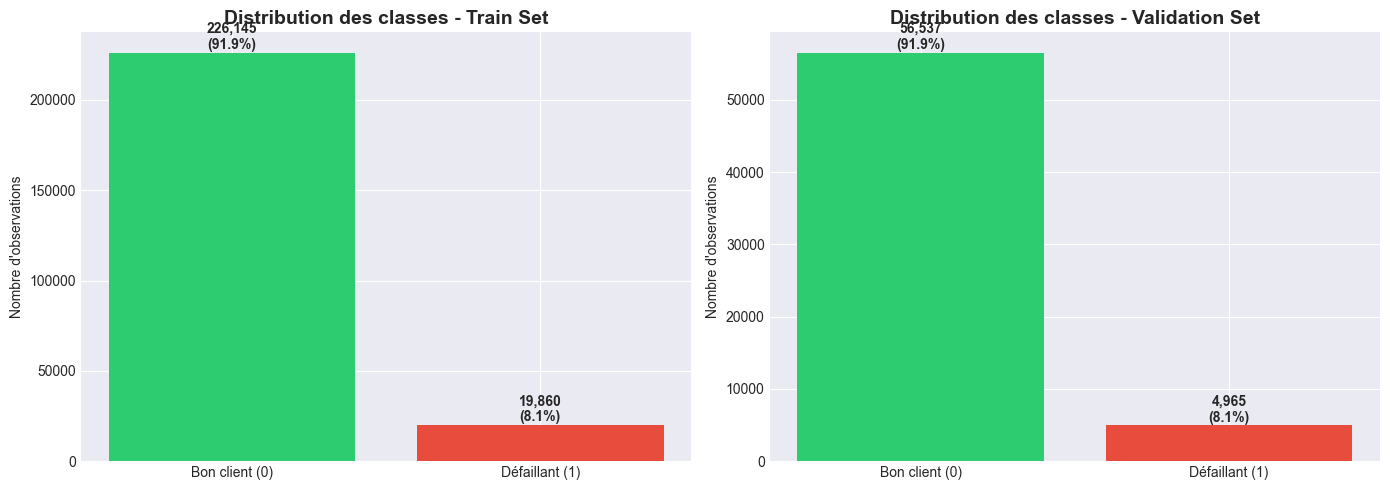

In [7]:
# Visualisation du déséquilibre
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Train
axes[0].bar(
    ['Bon client (0)', 'Défaillant (1)'],
    count_train.values,
    color=['#2ecc71', '#e74c3c']
)
axes[0].set_title('Distribution des classes - Train Set', fontsize=14, fontweight='bold')
axes[0].set_ylabel("Nombre d'observations")

for i, v in enumerate(count_train.values):
    axes[0].text(
        i,
        v + 500,
        f'{v:,}\n({dist_train.values[i]*100:.1f}%)',
        ha='center',
        va='bottom',
        fontweight='bold'
    )

# Validation
axes[1].bar(
    ['Bon client (0)', 'Défaillant (1)'],
    count_valid.values,
    color=['#2ecc71', '#e74c3c']
)
axes[1].set_title('Distribution des classes - Validation Set', fontsize=14, fontweight='bold')
axes[1].set_ylabel("Nombre d'observations")

for i, v in enumerate(count_valid.values):
    axes[1].text(
        i,
        v + 100,
        f'{v:,}\n({dist_valid.values[i]*100:.1f}%)',
        ha='center',
        va='bottom',
        fontweight='bold'
    )

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'desequilibre_initial.png', dpi=300, bbox_inches='tight')

print("Figure sauvegardée : desequilibre_initial.png")


## 5. Application du Preprocessing

In [8]:
# Application du preprocessing
print("Application du preprocessing...\n")

X_train_processed = preprocesseur.transform(X_train)
X_valid_processed = preprocesseur.transform(X_valid)

print(f"Données après preprocessing :")
print(f"  X_train_processed : {X_train_processed.shape}")
print(f"  X_valid_processed : {X_valid_processed.shape}")

# Vérification des NaN
nan_train = np.isnan(X_train_processed).sum()
nan_valid = np.isnan(X_valid_processed).sum()

print(f"\nVérification des NaN :")
print(f"  X_train_processed : {nan_train:,} NaN")
print(f"  X_valid_processed : {nan_valid:,} NaN")

# Nettoyage si nécessaire
if nan_train > 0 or nan_valid > 0:
    print(f"\nATTENTION : NaN détectés")
    print(f"Nettoyage avec np.nan_to_num() (remplace NaN par 0)...")
    
    X_train_processed = np.nan_to_num(X_train_processed, nan=0.0, copy=False)
    X_valid_processed = np.nan_to_num(X_valid_processed, nan=0.0, copy=False)
    
    # Vérification finale
    print(f"Vérification après nettoyage :")
    print(f"  X_train_processed : {np.isnan(X_train_processed).sum():,} NaN")
    print(f"  X_valid_processed : {np.isnan(X_valid_processed).sum():,} NaN")

print("\nPreprocessing terminé avec succès")

Application du preprocessing...

Données après preprocessing :
  X_train_processed : (246005, 804)
  X_valid_processed : (61502, 804)

Vérification des NaN :
  X_train_processed : 47,804,703 NaN
  X_valid_processed : 11,964,490 NaN

ATTENTION : NaN détectés
Nettoyage avec np.nan_to_num() (remplace NaN par 0)...
Vérification après nettoyage :
  X_train_processed : 0 NaN
  X_valid_processed : 0 NaN

Preprocessing terminé avec succès


## 6. Baseline : Modèle sans Correction du Déséquilibre

Nous entraînons d'abord un modèle de référence sans correction du déséquilibre pour établir une baseline.

In [9]:
print("=" * 70)
print("BASELINE : SANS CORRECTION DU DÉSÉQUILIBRE")
print("=" * 70)

# Entraînement du modèle baseline
baseline_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1,
    class_weight=None  # Pas de correction
)

print("\nEntraînement du modèle baseline...")
baseline_model.fit(X_train_processed, y_train)

# Prédictions
y_pred_baseline = baseline_model.predict(X_valid_processed)
y_pred_proba_baseline = baseline_model.predict_proba(X_valid_processed)[:, 1]

# Métriques
recall_baseline = recall_score(y_valid, y_pred_baseline)
precision_baseline = precision_score(y_valid, y_pred_baseline)
f1_baseline = f1_score(y_valid, y_pred_baseline)
roc_auc_baseline = roc_auc_score(y_valid, y_pred_proba_baseline)

# Coût métier
cout_baseline, details_baseline = cout_metier(y_valid, y_pred_baseline)

print("\nRésultats Baseline :")
print(f"  Recall    : {recall_baseline:.4f}")
print(f"  Precision : {precision_baseline:.4f}")
print(f"  F1-Score  : {f1_baseline:.4f}")
print(f"  ROC-AUC   : {roc_auc_baseline:.4f}")
print(f"\nCoût métier :")
print(f"  Coût total        : {cout_baseline:,.0f}")
print(f"  Faux négatifs (FN): {details_baseline['faux_negatifs']} (coût: {details_baseline['cout_fn_total']:,.0f})")
print(f"  Faux positifs (FP): {details_baseline['faux_positifs']} (coût: {details_baseline['cout_fp_total']:,.0f})")

# Matrice de confusion
cm_baseline = confusion_matrix(y_valid, y_pred_baseline)
print("\nMatrice de confusion :")
print(cm_baseline)

BASELINE : SANS CORRECTION DU DÉSÉQUILIBRE

Entraînement du modèle baseline...

Résultats Baseline :
  Recall    : 0.0000
  Precision : 0.0000
  F1-Score  : 0.0000
  ROC-AUC   : 0.7423

Coût métier :
  Coût total        : 49,650
  Faux négatifs (FN): 4965 (coût: 49,650)
  Faux positifs (FP): 0 (coût: 0)

Matrice de confusion :
[[56537     0]
 [ 4965     0]]


## 7. Méthode 1 : SMOTE (Oversampling)

**SMOTE** (Synthetic Minority Over-sampling Technique) génère des exemples synthétiques de la classe minoritaire en interpolant entre des exemples existants.

In [10]:
print("=" * 70)
print("MÉTHODE 1 : SMOTE (OVERSAMPLING)")
print("=" * 70)

# Application de SMOTE
smote = SMOTE(random_state=42, k_neighbors=5)
print("\nApplication de SMOTE...")
X_train_smote, y_train_smote = smote.fit_resample(X_train_processed, y_train)

# Vérification du rééquilibrage
dist_smote = pd.Series(y_train_smote).value_counts(normalize=True).sort_index()
count_smote = pd.Series(y_train_smote).value_counts().sort_index()

print(f"\nAprès SMOTE :")
print(f"  Classe 0 : {count_smote[0]:,} ({dist_smote[0]*100:.2f}%)")
print(f"  Classe 1 : {count_smote[1]:,} ({dist_smote[1]*100:.2f}%)")
print(f"  Total : {len(y_train_smote):,} samples")
print(f"  Augmentation : +{len(y_train_smote) - len(y_train):,} samples")

# Entraînement du modèle
model_smote = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

print("\nEntraînement du modèle avec SMOTE...")
model_smote.fit(X_train_smote, y_train_smote)

# Prédictions
y_pred_smote = model_smote.predict(X_valid_processed)
y_pred_proba_smote = model_smote.predict_proba(X_valid_processed)[:, 1]

# Métriques
recall_smote = recall_score(y_valid, y_pred_smote)
precision_smote = precision_score(y_valid, y_pred_smote)
f1_smote = f1_score(y_valid, y_pred_smote)
roc_auc_smote = roc_auc_score(y_valid, y_pred_proba_smote)

# Coût métier
cout_smote, details_smote = cout_metier(y_valid, y_pred_smote)

print("\nRésultats SMOTE :")
print(f"  Recall    : {recall_smote:.4f} (baseline: {recall_baseline:.4f})")
print(f"  Precision : {precision_smote:.4f} (baseline: {precision_baseline:.4f})")
print(f"  F1-Score  : {f1_smote:.4f} (baseline: {f1_baseline:.4f})")
print(f"  ROC-AUC   : {roc_auc_smote:.4f} (baseline: {roc_auc_baseline:.4f})")
print(f"\nCoût métier :")
print(f"  Coût total        : {cout_smote:,.0f} (baseline: {cout_baseline:,.0f})")
print(f"  Faux négatifs (FN): {details_smote['faux_negatifs']} (baseline: {details_baseline['faux_negatifs']})")
print(f"  Faux positifs (FP): {details_smote['faux_positifs']} (baseline: {details_baseline['faux_positifs']})")

cm_smote = confusion_matrix(y_valid, y_pred_smote)

MÉTHODE 1 : SMOTE (OVERSAMPLING)

Application de SMOTE...

Après SMOTE :
  Classe 0 : 226,145 (50.00%)
  Classe 1 : 226,145 (50.00%)
  Total : 452,290 samples
  Augmentation : +206,285 samples

Entraînement du modèle avec SMOTE...

Résultats SMOTE :
  Recall    : 0.0439 (baseline: 0.0000)
  Precision : 0.2662 (baseline: 0.0000)
  F1-Score  : 0.0754 (baseline: 0.0000)
  ROC-AUC   : 0.6880 (baseline: 0.7423)

Coût métier :
  Coût total        : 48,071 (baseline: 49,650)
  Faux négatifs (FN): 4747 (baseline: 4965)
  Faux positifs (FP): 601 (baseline: 0)


## 8. Méthode 2 : RandomUnderSampler (Undersampling)

**RandomUnderSampler** réduit la classe majoritaire en supprimant aléatoirement des exemples pour équilibrer les classes.

In [11]:
print("=" * 70)
print("MÉTHODE 2 : RANDOMUNDERSAMPLER (UNDERSAMPLING)")
print("=" * 70)

# Application du RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
print("\nApplication de RandomUnderSampler...")
X_train_rus, y_train_rus = rus.fit_resample(X_train_processed, y_train)

# Vérification du rééquilibrage
dist_rus = pd.Series(y_train_rus).value_counts(normalize=True).sort_index()
count_rus = pd.Series(y_train_rus).value_counts().sort_index()

print(f"\nAprès RandomUnderSampler :")
print(f"  Classe 0 : {count_rus[0]:,} ({dist_rus[0]*100:.2f}%)")
print(f"  Classe 1 : {count_rus[1]:,} ({dist_rus[1]*100:.2f}%)")
print(f"  Total : {len(y_train_rus):,} samples")
print(f"  Réduction : {len(y_train) - len(y_train_rus):,} samples supprimés")

# Entraînement du modèle
model_rus = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

print("\nEntraînement du modèle avec RandomUnderSampler...")
model_rus.fit(X_train_rus, y_train_rus)

# Prédictions
y_pred_rus = model_rus.predict(X_valid_processed)
y_pred_proba_rus = model_rus.predict_proba(X_valid_processed)[:, 1]

# Métriques
recall_rus = recall_score(y_valid, y_pred_rus)
precision_rus = precision_score(y_valid, y_pred_rus)
f1_rus = f1_score(y_valid, y_pred_rus)
roc_auc_rus = roc_auc_score(y_valid, y_pred_proba_rus)

# Coût métier
cout_rus, details_rus = cout_metier(y_valid, y_pred_rus)

print("\nRésultats RandomUnderSampler :")
print(f"  Recall    : {recall_rus:.4f} (baseline: {recall_baseline:.4f})")
print(f"  Precision : {precision_rus:.4f} (baseline: {precision_baseline:.4f})")
print(f"  F1-Score  : {f1_rus:.4f} (baseline: {f1_baseline:.4f})")
print(f"  ROC-AUC   : {roc_auc_rus:.4f} (baseline: {roc_auc_baseline:.4f})")
print(f"\nCoût métier :")
print(f"  Coût total        : {cout_rus:,.0f} (baseline: {cout_baseline:,.0f})")
print(f"  Faux négatifs (FN): {details_rus['faux_negatifs']} (baseline: {details_baseline['faux_negatifs']})")
print(f"  Faux positifs (FP): {details_rus['faux_positifs']} (baseline: {details_baseline['faux_positifs']})")

cm_rus = confusion_matrix(y_valid, y_pred_rus)

MÉTHODE 2 : RANDOMUNDERSAMPLER (UNDERSAMPLING)

Application de RandomUnderSampler...

Après RandomUnderSampler :
  Classe 0 : 19,860 (50.00%)
  Classe 1 : 19,860 (50.00%)
  Total : 39,720 samples
  Réduction : 206,285 samples supprimés

Entraînement du modèle avec RandomUnderSampler...

Résultats RandomUnderSampler :
  Recall    : 0.6788 (baseline: 0.0000)
  Precision : 0.1587 (baseline: 0.0000)
  F1-Score  : 0.2572 (baseline: 0.0000)
  ROC-AUC   : 0.7442 (baseline: 0.7423)

Coût métier :
  Coût total        : 33,819 (baseline: 49,650)
  Faux négatifs (FN): 1595 (baseline: 4965)
  Faux positifs (FP): 17869 (baseline: 0)


## 9. Méthode 3 : SMOTEENN (Combinaison Over + Under)

**SMOTEENN** combine SMOTE (oversampling) avec Edited Nearest Neighbours (nettoyage) pour créer un ensemble de données équilibré et de meilleure qualité.

In [12]:
print("=" * 50)
print("INFORMATIONS SUR LE DATASET")
print("=" * 50)
print(f"Lignes d'entraînement : {X_train_processed.shape[0]:,}")
print(f"Nombre de features : {X_train_processed.shape[1]}")
print(f"Distribution : \n{pd.Series(y_train).value_counts()}")
print("=" * 50)

INFORMATIONS SUR LE DATASET
Lignes d'entraînement : 246,005
Nombre de features : 804
Distribution : 
TARGET
0    226145
1     19860
Name: count, dtype: int64


In [13]:
print("=" * 70)
print("MÉTHODE 3 : SMOTEENN (COMBINAISON OVER + UNDER)")
print("=" * 70)

# Application de SMOTEENN
smoteenn = SMOTEENN(random_state=42)
print("\nApplication de SMOTEENN...")
print("(Cette opération peut prendre quelques minutes...)")
X_train_smoteenn, y_train_smoteenn = smoteenn.fit_resample(X_train_processed, y_train)

# Vérification du rééquilibrage
dist_smoteenn = pd.Series(y_train_smoteenn).value_counts(normalize=True).sort_index()
count_smoteenn = pd.Series(y_train_smoteenn).value_counts().sort_index()

print(f"\nAprès SMOTEENN :")
print(f"  Classe 0 : {count_smoteenn[0]:,} ({dist_smoteenn[0]*100:.2f}%)")
print(f"  Classe 1 : {count_smoteenn[1]:,} ({dist_smoteenn[1]*100:.2f}%)")
print(f"  Total : {len(y_train_smoteenn):,} samples")
diff = len(y_train_smoteenn) - len(y_train)
print(f"  Variation : {'+' if diff > 0 else ''}{diff:,} samples")

# Entraînement du modèle
model_smoteenn = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

print("\nEntraînement du modèle avec SMOTEENN...")
model_smoteenn.fit(X_train_smoteenn, y_train_smoteenn)

# Prédictions
y_pred_smoteenn = model_smoteenn.predict(X_valid_processed)
y_pred_proba_smoteenn = model_smoteenn.predict_proba(X_valid_processed)[:, 1]

# Métriques
recall_smoteenn = recall_score(y_valid, y_pred_smoteenn)
precision_smoteenn = precision_score(y_valid, y_pred_smoteenn)
f1_smoteenn = f1_score(y_valid, y_pred_smoteenn)
roc_auc_smoteenn = roc_auc_score(y_valid, y_pred_proba_smoteenn)

# Coût métier
cout_smoteenn, details_smoteenn = cout_metier(y_valid, y_pred_smoteenn)

print("\nRésultats SMOTEENN :")
print(f"  Recall    : {recall_smoteenn:.4f} (baseline: {recall_baseline:.4f})")
print(f"  Precision : {precision_smoteenn:.4f} (baseline: {precision_baseline:.4f})")
print(f"  F1-Score  : {f1_smoteenn:.4f} (baseline: {f1_baseline:.4f})")
print(f"  ROC-AUC   : {roc_auc_smoteenn:.4f} (baseline: {roc_auc_baseline:.4f})")
print(f"\nCoût métier :")
print(f"  Coût total        : {cout_smoteenn:,.0f} (baseline: {cout_baseline:,.0f})")
print(f"  Faux négatifs (FN): {details_smoteenn['faux_negatifs']} (baseline: {details_baseline['faux_negatifs']})")
print(f"  Faux positifs (FP): {details_smoteenn['faux_positifs']} (baseline: {details_baseline['faux_positifs']})")

cm_smoteenn = confusion_matrix(y_valid, y_pred_smoteenn)

MÉTHODE 3 : SMOTEENN (COMBINAISON OVER + UNDER)

Application de SMOTEENN...
(Cette opération peut prendre quelques minutes...)

Après SMOTEENN :
  Classe 0 : 131,471 (38.26%)
  Classe 1 : 212,111 (61.74%)
  Total : 343,582 samples
  Variation : +97,577 samples

Entraînement du modèle avec SMOTEENN...

Résultats SMOTEENN :
  Recall    : 0.2649 (baseline: 0.0000)
  Precision : 0.1971 (baseline: 0.0000)
  F1-Score  : 0.2260 (baseline: 0.0000)
  ROC-AUC   : 0.6948 (baseline: 0.7423)

Coût métier :
  Coût total        : 41,856 (baseline: 49,650)
  Faux négatifs (FN): 3650 (baseline: 4965)
  Faux positifs (FP): 5356 (baseline: 0)


## 10. Tableau Comparatif des Résultats

In [14]:
# Création du tableau comparatif
resultats = pd.DataFrame({
    'Méthode': ['Baseline', 'SMOTE', 'RandomUnderSampler', 'SMOTEENN'],
    'Recall': [recall_baseline, recall_smote, recall_rus, recall_smoteenn],
    'Precision': [precision_baseline, precision_smote, precision_rus, precision_smoteenn],
    'F1-Score': [f1_baseline, f1_smote, f1_rus, f1_smoteenn],
    'ROC-AUC': [roc_auc_baseline, roc_auc_smote, roc_auc_rus, roc_auc_smoteenn],
    'Coût Métier': [cout_baseline, cout_smote, cout_rus, cout_smoteenn],
    'Faux Négatifs': [
        details_baseline['faux_negatifs'],
        details_smote['faux_negatifs'],
        details_rus['faux_negatifs'],
        details_smoteenn['faux_negatifs']
    ],
    'Faux Positifs': [
        details_baseline['faux_positifs'],
        details_smote['faux_positifs'],
        details_rus['faux_positifs'],
        details_smoteenn['faux_positifs']
    ]
})

print("=" * 100)
print("TABLEAU COMPARATIF DES MÉTHODES")
print("=" * 100)
print(resultats.to_string(index=False))
print("=" * 100)

# Identifier la meilleure méthode pour chaque critère
print("\nMeilleure méthode par critère :")
print(f"  Recall le plus élevé      : {resultats.loc[resultats['Recall'].idxmax(), 'Méthode']}")
print(f"  Precision la plus élevée  : {resultats.loc[resultats['Precision'].idxmax(), 'Méthode']}")
print(f"  F1-Score le plus élevé    : {resultats.loc[resultats['F1-Score'].idxmax(), 'Méthode']}")
print(f"  ROC-AUC le plus élevé     : {resultats.loc[resultats['ROC-AUC'].idxmax(), 'Méthode']}")
print(f"  Coût Métier le plus bas   : {resultats.loc[resultats['Coût Métier'].idxmin(), 'Méthode']}")

TABLEAU COMPARATIF DES MÉTHODES
           Méthode   Recall  Precision  F1-Score  ROC-AUC  Coût Métier  Faux Négatifs  Faux Positifs
          Baseline 0.000000   0.000000  0.000000 0.742323        49650           4965              0
             SMOTE 0.043907   0.266178  0.075380 0.688029        48071           4747            601
RandomUnderSampler 0.678751   0.158670  0.257213 0.744150        33819           1595          17869
          SMOTEENN 0.264854   0.197122  0.226023 0.694780        41856           3650           5356

Meilleure méthode par critère :
  Recall le plus élevé      : RandomUnderSampler
  Precision la plus élevée  : SMOTE
  F1-Score le plus élevé    : RandomUnderSampler
  ROC-AUC le plus élevé     : RandomUnderSampler
  Coût Métier le plus bas   : RandomUnderSampler


## 11. Visualisations Comparatives

Figure sauvegardée : comparaison_methodes.png


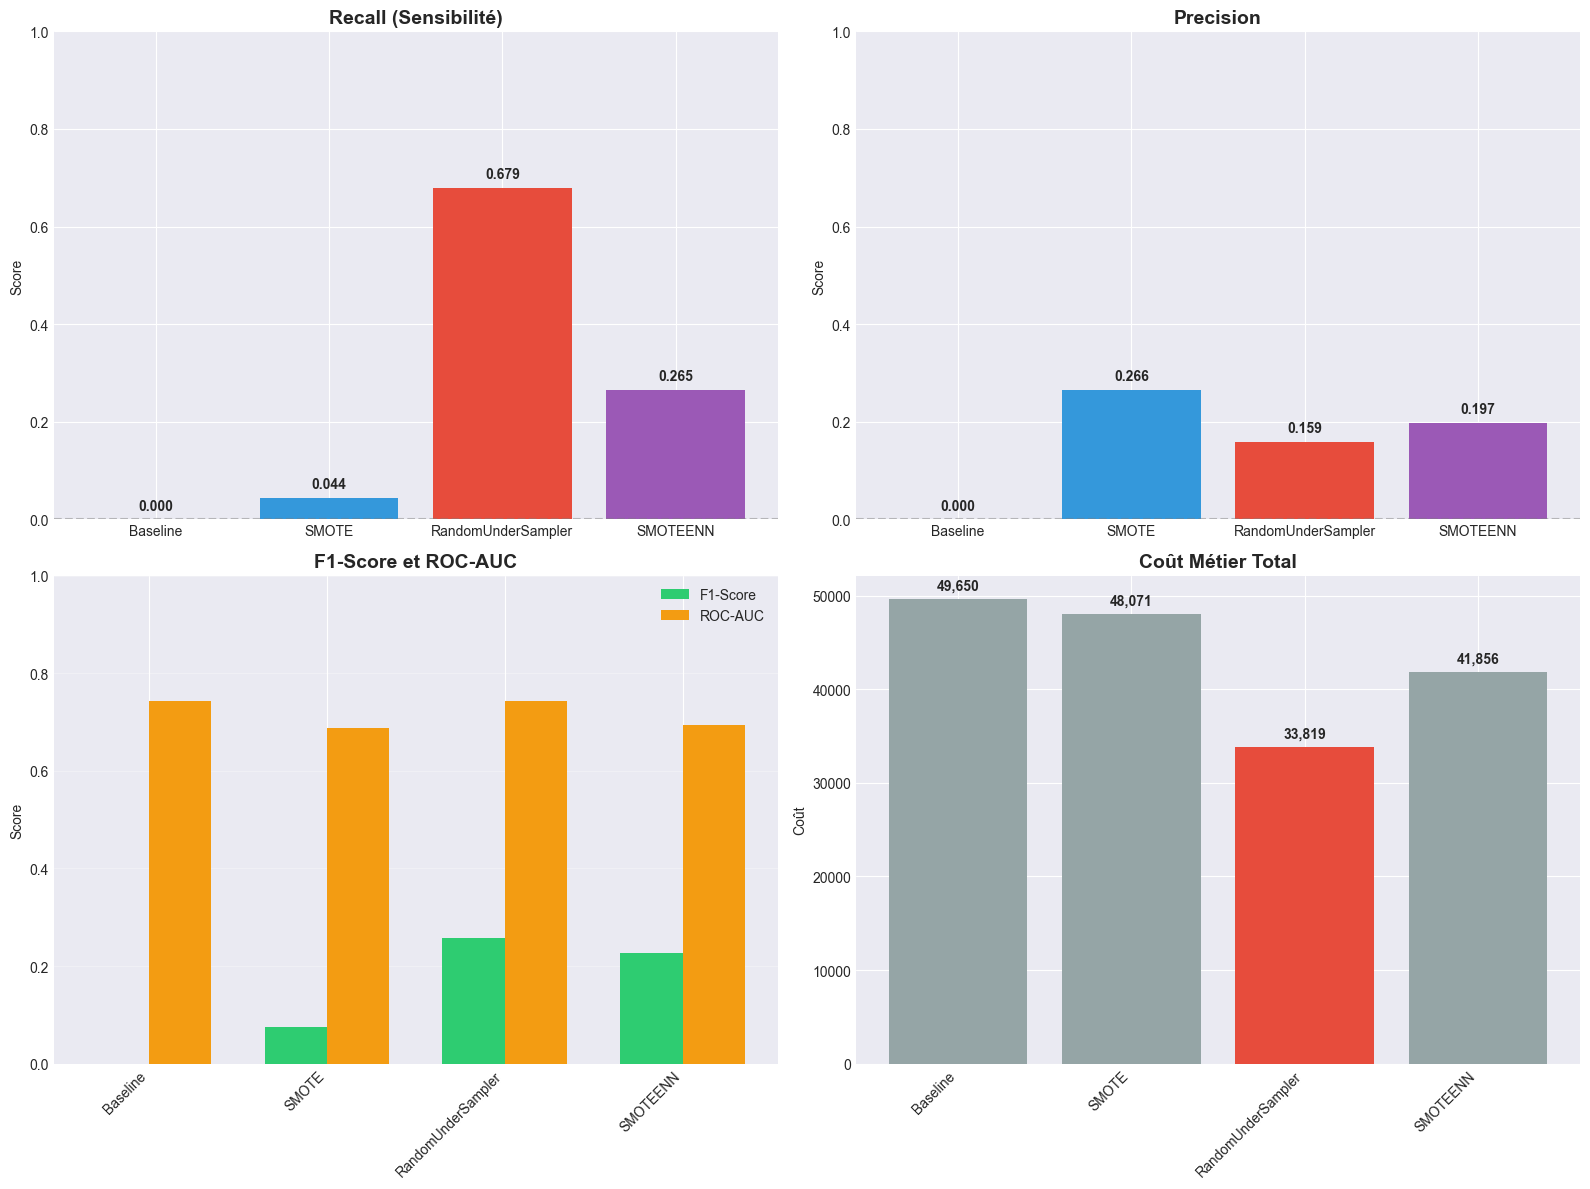

In [15]:
# Graphique comparatif des métriques
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Recall
axes[0, 0].bar(
    resultats['Méthode'],
    resultats['Recall'],
    color=['#95a5a6', '#3498db', '#e74c3c', '#9b59b6']
)
axes[0, 0].set_title('Recall (Sensibilité)', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Score')
axes[0, 0].set_ylim([0, 1])
axes[0, 0].axhline(y=recall_baseline, color='gray', linestyle='--', alpha=0.5)

for i, v in enumerate(resultats['Recall']):
    axes[0, 0].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

# 2. Precision
axes[0, 1].bar(
    resultats['Méthode'],
    resultats['Precision'],
    color=['#95a5a6', '#3498db', '#e74c3c', '#9b59b6']
)
axes[0, 1].set_title('Precision', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Score')
axes[0, 1].set_ylim([0, 1])
axes[0, 1].axhline(y=precision_baseline, color='gray', linestyle='--', alpha=0.5)

for i, v in enumerate(resultats['Precision']):
    axes[0, 1].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

# 3. F1-Score et ROC-AUC
x = np.arange(len(resultats))
width = 0.35

axes[1, 0].bar(x - width/2, resultats['F1-Score'], width, label='F1-Score', color='#2ecc71')
axes[1, 0].bar(x + width/2, resultats['ROC-AUC'], width, label='ROC-AUC', color='#f39c12')

axes[1, 0].set_title('F1-Score et ROC-AUC', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('Score')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(resultats['Méthode'], rotation=45, ha='right')
axes[1, 0].set_ylim([0, 1])
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. Coût Métier
colors_cout = [
    '#e74c3c' if c == resultats['Coût Métier'].min() else '#95a5a6'
    for c in resultats['Coût Métier']
]

axes[1, 1].bar(resultats['Méthode'], resultats['Coût Métier'], color=colors_cout)
axes[1, 1].set_title('Coût Métier Total', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Coût')
axes[1, 1].set_xticklabels(resultats['Méthode'], rotation=45, ha='right')

for i, v in enumerate(resultats['Coût Métier']):
    axes[1, 1].text(i, v + max(resultats['Coût Métier']) * 0.02, f'{v:,.0f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'comparaison_methodes.png', dpi=300, bbox_inches='tight')

print("Figure sauvegardée : comparaison_methodes.png")


## 12. Matrices de Confusion Comparées

Figure sauvegardée : matrices_confusion_comparaison.png


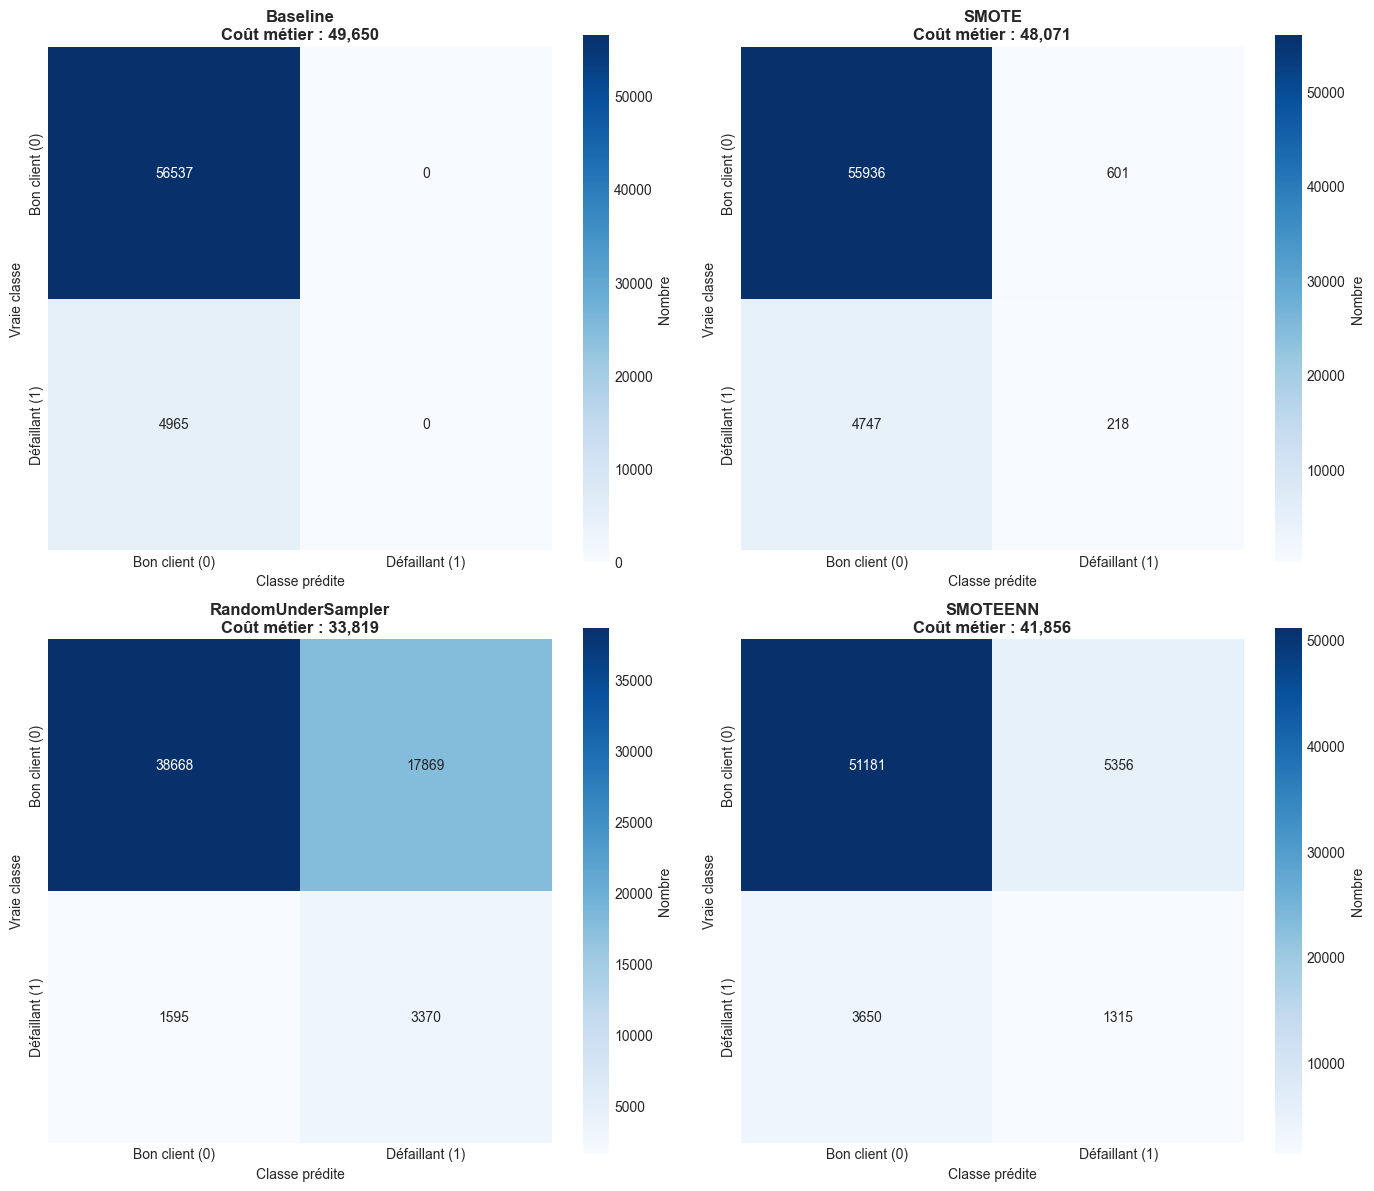

In [16]:
# Visualisation des matrices de confusion
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.ravel()

matrices = [cm_baseline, cm_smote, cm_rus, cm_smoteenn]
titres = ['Baseline', 'SMOTE', 'RandomUnderSampler', 'SMOTEENN']
couts = [cout_baseline, cout_smote, cout_rus, cout_smoteenn]

for idx, (cm, titre, cout) in enumerate(zip(matrices, titres, couts)):
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        ax=axes[idx],
        cbar_kws={'label': 'Nombre'},
        square=True
    )
    axes[idx].set_title(f'{titre}\nCoût métier : {cout:,.0f}', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Vraie classe')
    axes[idx].set_xlabel('Classe prédite')
    axes[idx].set_xticklabels(['Bon client (0)', 'Défaillant (1)'])
    axes[idx].set_yticklabels(['Bon client (0)', 'Défaillant (1)'])

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'matrices_confusion_comparaison.png', dpi=300, bbox_inches='tight')

print("Figure sauvegardée : matrices_confusion_comparaison.png")


## 13. Courbes ROC Comparées

Figure sauvegardée : courbes_roc_comparaison.png


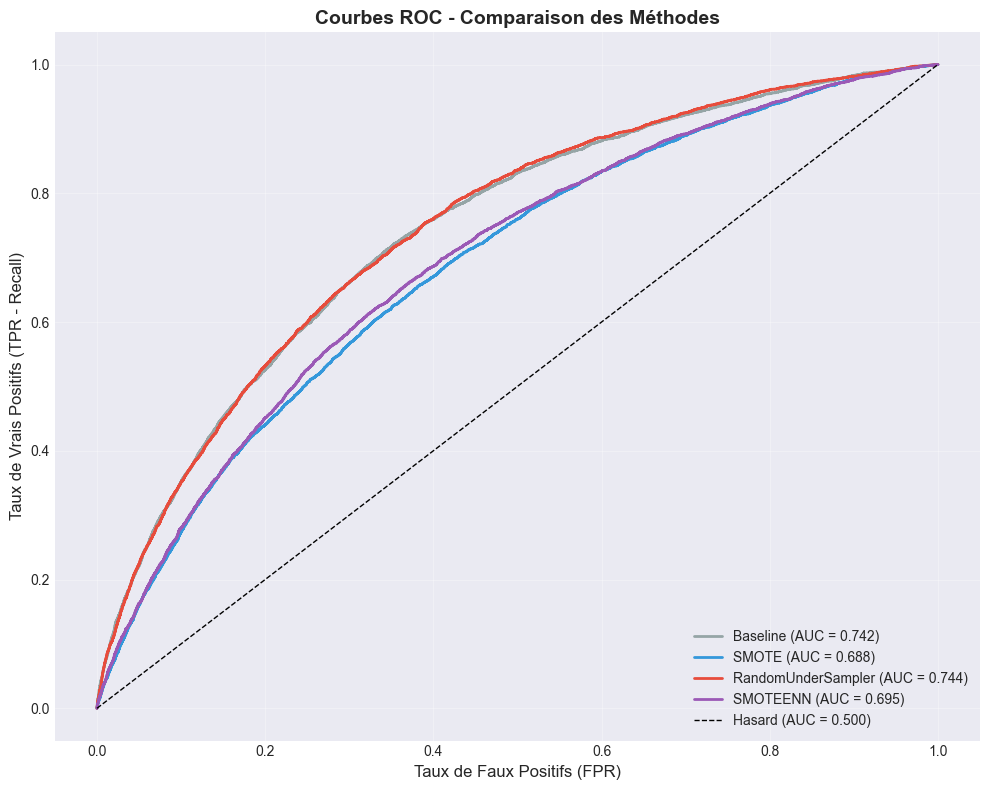

In [17]:
# Calcul des courbes ROC
fpr_baseline, tpr_baseline, _ = roc_curve(y_valid, y_pred_proba_baseline)
fpr_smote, tpr_smote, _ = roc_curve(y_valid, y_pred_proba_smote)
fpr_rus, tpr_rus, _ = roc_curve(y_valid, y_pred_proba_rus)
fpr_smoteenn, tpr_smoteenn, _ = roc_curve(y_valid, y_pred_proba_smoteenn)

# Visualisation
plt.figure(figsize=(10, 8))

plt.plot(
    fpr_baseline, tpr_baseline,
    label=f'Baseline (AUC = {roc_auc_baseline:.3f})',
    linewidth=2, color='#95a5a6'
)
plt.plot(
    fpr_smote, tpr_smote,
    label=f'SMOTE (AUC = {roc_auc_smote:.3f})',
    linewidth=2, color='#3498db'
)
plt.plot(
    fpr_rus, tpr_rus,
    label=f'RandomUnderSampler (AUC = {roc_auc_rus:.3f})',
    linewidth=2, color='#e74c3c'
)
plt.plot(
    fpr_smoteenn, tpr_smoteenn,
    label=f'SMOTEENN (AUC = {roc_auc_smoteenn:.3f})',
    linewidth=2, color='#9b59b6'
)

# Ligne du hasard
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Hasard (AUC = 0.500)')

plt.xlabel('Taux de Faux Positifs (FPR)', fontsize=12)
plt.ylabel('Taux de Vrais Positifs (TPR - Recall)', fontsize=12)
plt.title('Courbes ROC - Comparaison des Méthodes', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'courbes_roc_comparaison.png', dpi=300, bbox_inches='tight')

print("Figure sauvegardée : courbes_roc_comparaison.png")


## 14. Analyse et Décision Finale

### Critères de décision

Pour ce projet de scoring crédit, nos priorités sont :

1. **Minimiser les faux négatifs** (ne pas prêter à un défaillant) - Impact financier élevé
2. **Minimiser le coût métier global**
3. **Maintenir un bon équilibre** entre Recall et Precision
4. **Optimiser le ROC-AUC** pour la capacité discriminante du modèle

### Analyse comparative

In [18]:
print("=" * 100)
print("ANALYSE DÉTAILLÉE ET RECOMMANDATION")
print("=" * 100)

# Analyse
print("\n1. ANALYSE PAR MÉTRIQUE :")
print("\n   a) Coût métier (critère principal) :")
for idx, row in resultats.iterrows():
    marker = " <-- MEILLEUR" if row['Coût Métier'] == resultats['Coût Métier'].min() else ""
    print(f"      {row['Méthode']:20s} : {row['Coût Métier']:8,.0f}{marker}")

print("\n   b) Recall (détection des défaillants) :")
for idx, row in resultats.iterrows():
    marker = " <-- MEILLEUR" if row['Recall'] == resultats['Recall'].max() else ""
    print(f"      {row['Méthode']:20s} : {row['Recall']:.4f}{marker}")

print("\n   c) ROC-AUC (capacité discriminante) :")
for idx, row in resultats.iterrows():
    marker = " <-- MEILLEUR" if row['ROC-AUC'] == resultats['ROC-AUC'].max() else ""
    print(f"      {row['Méthode']:20s} : {row['ROC-AUC']:.4f}{marker}")

# Identifier la meilleure méthode
meilleure_cout = resultats.loc[resultats['Coût Métier'].idxmin(), 'Méthode']
meilleure_recall = resultats.loc[resultats['Recall'].idxmax(), 'Méthode']
meilleure_roc = resultats.loc[resultats['ROC-AUC'].idxmax(), 'Méthode']

print("\n" + "=" * 100)
print("2. RECOMMANDATION FINALE :")
print("=" * 100)

# Logique de décision
if meilleure_cout == meilleure_recall:
    methode_retenue = meilleure_cout
    raison = "Cette méthode minimise le coût métier ET maximise le recall"
else:
    # Prioriser le coût métier
    methode_retenue = meilleure_cout
    raison = "Cette méthode minimise le coût métier (critère prioritaire pour le métier)"

print(f"\nMéthode retenue : {methode_retenue}")
print(f"\nRaison : {raison}")

# Détails de la méthode retenue
idx_retenu = resultats[resultats['Méthode'] == methode_retenue].index[0]
print(f"\nPerformances de {methode_retenue} :")
print(f"  Recall          : {resultats.loc[idx_retenu, 'Recall']:.4f}")
print(f"  Precision       : {resultats.loc[idx_retenu, 'Precision']:.4f}")
print(f"  F1-Score        : {resultats.loc[idx_retenu, 'F1-Score']:.4f}")
print(f"  ROC-AUC         : {resultats.loc[idx_retenu, 'ROC-AUC']:.4f}")
print(f"  Coût métier     : {resultats.loc[idx_retenu, 'Coût Métier']:,.0f}")
print(f"  Faux négatifs   : {int(resultats.loc[idx_retenu, 'Faux Négatifs'])}")
print(f"  Faux positifs   : {int(resultats.loc[idx_retenu, 'Faux Positifs'])}")

# Comparaison avec baseline
print(f"\nGains par rapport à la baseline :")
gain_cout = ((cout_baseline - resultats.loc[idx_retenu, 'Coût Métier']) / cout_baseline) * 100
gain_recall = ((resultats.loc[idx_retenu, 'Recall'] - recall_baseline) / recall_baseline) * 100
print(f"  Réduction coût métier : {gain_cout:+.1f}%")
print(f"  Amélioration recall   : {gain_recall:+.1f}%")

print("=" * 100)

ANALYSE DÉTAILLÉE ET RECOMMANDATION

1. ANALYSE PAR MÉTRIQUE :

   a) Coût métier (critère principal) :
      Baseline             :   49,650
      SMOTE                :   48,071
      RandomUnderSampler   :   33,819 <-- MEILLEUR
      SMOTEENN             :   41,856

   b) Recall (détection des défaillants) :
      Baseline             : 0.0000
      SMOTE                : 0.0439
      RandomUnderSampler   : 0.6788 <-- MEILLEUR
      SMOTEENN             : 0.2649

   c) ROC-AUC (capacité discriminante) :
      Baseline             : 0.7423
      SMOTE                : 0.6880
      RandomUnderSampler   : 0.7442 <-- MEILLEUR
      SMOTEENN             : 0.6948

2. RECOMMANDATION FINALE :

Méthode retenue : RandomUnderSampler

Raison : Cette méthode minimise le coût métier ET maximise le recall

Performances de RandomUnderSampler :
  Recall          : 0.6788
  Precision       : 0.1587
  F1-Score        : 0.2572
  ROC-AUC         : 0.7442
  Coût métier     : 33,819
  Faux négatifs   : 15

## 15. Sauvegarde de la Décision

In [19]:
# Sauvegarde de la décision et des résultats
decision = {
    'methode_retenue': methode_retenue,
    'date_analyse': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'metriques': {
        'recall': float(resultats.loc[idx_retenu, 'Recall']),
        'precision': float(resultats.loc[idx_retenu, 'Precision']),
        'f1_score': float(resultats.loc[idx_retenu, 'F1-Score']),
        'roc_auc': float(resultats.loc[idx_retenu, 'ROC-AUC']),
        'cout_metier': float(resultats.loc[idx_retenu, 'Coût Métier']),
        'faux_negatifs': int(resultats.loc[idx_retenu, 'Faux Négatifs']),
        'faux_positifs': int(resultats.loc[idx_retenu, 'Faux Positifs'])
    },
    'comparaison_baseline': {
        'gain_cout_pct': float(gain_cout),
        'gain_recall_pct': float(gain_recall)
    },
    'toutes_methodes': resultats.to_dict('records')
}

# Sauvegarder en JSON
decision_path = ARTIFACTS_DIR / 'decision_desequilibre.json'
with open(decision_path, 'w', encoding='utf-8') as f:
    json.dump(decision, f, indent=2, ensure_ascii=False)

print(f"Décision sauvegardée : {decision_path}")

# Sauvegarder aussi le tableau comparatif en CSV
resultats_path = ARTIFACTS_DIR / 'comparaison_methodes_desequilibre.csv'
resultats.to_csv(resultats_path, index=False)
print(f"Tableau comparatif sauvegardé : {resultats_path}")

print("\nSauvegarde terminée avec succès")

Décision sauvegardée : C:\Users\Utilisateur\Downloads\notebookmentordemain\artifacts\decision_desequilibre.json
Tableau comparatif sauvegardé : C:\Users\Utilisateur\Downloads\notebookmentordemain\artifacts\comparaison_methodes_desequilibre.csv

Sauvegarde terminée avec succès


## Conclusion

Ce notebook a permis de :

1. Tester 3 approches de rééquilibrage (undersampling, oversampling, combinaison)
2. Évaluer chaque approche avec des métriques techniques ET métier
3. Identifier la meilleure stratégie pour notre cas d'usage crédit
4. Documenter et sauvegarder la décision pour traçabilité

### Prochaines étapes

- Utiliser la méthode retenue dans le pipeline de modélisation
- Affiner les hyperparamètres du modèle
- Valider sur le test set final

---

**Notebook réalisé par Stéphane Barre**  
**Projet 7 - OpenClassrooms - Data Scientist**